# SSNE - Zadanie 1
Jan Jędrzejewski, Dominik Łopatecki

In [266]:
import torch
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import torch.utils.data as data
from torch.utils.data import dataloader
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

def rmsle(y_true,y_pred):
    n = len(y_true)
    msle = np.mean([(np.log(max(y_pred[i],0) + 1) - np.log(y_true[i] + 1)) ** 2.0 for i in range(n)])
    return np.sqrt(msle)

device

device(type='cuda')

# Wczytanie danych

In [267]:
file_name = "data.csv"
df = pd.read_csv(file_name, delimiter=",")
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,17089,2012-12-19,4,1,12,19,0,3,1,1,0.38,0.3939,0.50,0.3881,7,329,336
10882,17090,2012-12-19,4,1,12,20,0,3,1,1,0.36,0.3485,0.57,0.2239,10,231,241
10883,17091,2012-12-19,4,1,12,21,0,3,1,1,0.34,0.3182,0.61,0.2239,4,164,168
10884,17092,2012-12-19,4,1,12,22,0,3,1,1,0.34,0.3485,0.61,0.0896,12,117,129


In [268]:
x = df.values[:,2:14]
y = df.values[:,-1]

scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)
len(x[1,])

12

In [269]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=2137)

print(len(train_y), len(test_y))

8708 2178


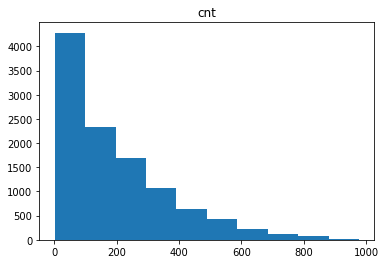

In [270]:
plt.hist(y)
plt.title("cnt")
plt.show()

In [271]:
train_dataset = data.TensorDataset(torch.from_numpy(train_x.astype(float)), torch.from_numpy(train_y.astype(float)))
train_data_loader = data.DataLoader(train_dataset, batch_size=256,  shuffle=True)

In [272]:
test_dataset = data.TensorDataset(torch.from_numpy(test_x.astype(float)), torch.from_numpy(test_y.astype(float)))
test_data_loader = data.DataLoader(test_dataset, batch_size=256,  shuffle=False)

# Model sieci

In [273]:
act_fn_by_name = {
    "sigmoid": torch.sigmoid,
    "tanh": torch.tanh,
    "relu": F.relu,
    "leakyrelu": F.leaky_relu
}

In [274]:
class OneLayer(nn.Module):
    def __init__(self, num_inputs, num_hidden1, num_hidden2, num_hidden3, act_func):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden1)
        self.bn1 = nn.BatchNorm1d(num_hidden1)
        self.d = nn.Dropout(0.5)    # Dropout może być od 0.5 do nawet 0.8 - część odrzucona
        self.act_fn = act_fn_by_name[act_func]
        self.linear2 = nn.Linear(num_hidden1, num_hidden2)
        self.bn2 = nn.BatchNorm1d(num_hidden2)
        self.linear3 = nn.Linear(num_hidden2, num_hidden3)
        self.bn3 = nn.BatchNorm1d(num_hidden3)
        self.linear4 = nn.Linear(num_hidden3, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.d(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.d(x)
        x = self.act_fn(x)
        x = self.linear3(x)
        x = self.bn3(x)
        x = self.d(x)
        x = self.act_fn(x)
        x = self.linear4(x)
        # w trybie eval bachnorm i dropout nie działą
        return x

In [275]:
model = OneLayer(num_inputs=len(x[1,]), num_hidden1=5000, num_hidden2=2000, num_hidden3=200, act_func="relu")
model.cuda()

# Ustawiamy learning rate i regularyzacje zmian
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.01)

loss_module = nn.MSELoss()

# Trenowanie

In [276]:
def train_model(model):
  Loss = []
  model.train()
  for epoch in tqdm(range(100)):
    for data_inputs, data_labels in train_data_loader:
      data_inputs = data_inputs.to(torch.float)
      data_labels = data_labels.to(torch.float)
      data_inputs = data_inputs.to(device)
      data_labels = data_labels.to(device)

      preds = model(data_inputs)
      preds = preds.squeeze(dim=1)

      loss = loss_module(preds, data_labels)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()
      
    # print(f"Epoch: {epoch}, loss: {loss.item():.3}")
    Loss.append((loss.item()))

  plt.plot(Loss)
  plt.title("loss")
  # plt.yscale("log")
  plt.show()

100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


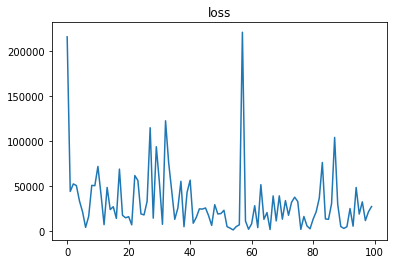

In [277]:
train_model(model)

# Walidacja modelu na zbiorze testowym

In [278]:
model.eval()
PREDS = []
with torch.no_grad():
    for data_inputs, data_labels in test_data_loader:
        data_inputs = data_inputs.to(torch.float)
        data_labels = data_labels.to(torch.float)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1)
        for pred in preds:
          PREDS.append(pred.cpu())
rmsle(test_y, PREDS)


0.4530607

# Generowanie predykcji dla zbioru ewaluacyjnego

In [279]:
df = pd.read_csv("evaluation_data.csv", delimiter=",")
df

In [280]:
ev = df.values[:,1:]
y = df.values[:, 1]
scaler_ev = StandardScaler()
scaler_ev.fit(ev)
ev = scaler_ev.transform(ev)

eval_dataset = torch.from_numpy(ev.astype(float))
eval_data_loader = data.DataLoader(eval_dataset, batch_size=len(ev), shuffle=False, drop_last=False)

In [281]:
model.eval()
PREDS = []
with torch.no_grad():
    for data_inputs in eval_data_loader:
        data_inputs = data_inputs.to(torch.float)
        data_inputs = data_inputs.to(device)
        preds = model(data_inputs)
        print(preds)
        preds = preds.squeeze(dim=1)
        for pred in preds:
          PREDS.append(pred.cpu())


In [282]:
pd.DataFrame(PREDS).to_csv("piatek_Jedrzejewski_Lopatecki.csv", index=False, header=None)